# RNA Sequence Analysis to detect cancer

---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,f_classif

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

## 1. Exploratory Data Analysis
Dataset is taken from UCI (https://archive.ics.uci.edu/ml/datasets), It has 802 samples, each sample containing expression values of 
more than 20K genes. Samples are having one of the types of tumor: BRCA, KIRC, COAD, LUAD and PRAD

In [3]:
rna_exp = pd.read_csv('../Dataset/data.csv', index_col=[0])
labels = pd.read_csv('../Dataset/labels.csv', index_col=[0])

In [4]:
rna_exp.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [5]:
labels.head()

,Class
sample_0,PRAD
sample_1,LUAD
sample_2,PRAD
sample_3,PRAD
sample_4,BRCA


In [6]:
pd.unique(labels.Class)

array(['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD'], dtype=object)

Hence total 5 unique cancer type we have to clusterise and categorise.

Different gene expression like gene_0,gene_1 or called levels tells us the variability between different samples, in RNA sequence data analysis, the gene expression value of one sample represents the mean of all expression values of the bulk population of cells.
So if the data have large mean for one of the gene then mean of all the bulk population is also higher and vice-versa.

### Merging both the data

In [7]:
rna_merged = pd.concat([rna_exp, labels], axis=1)
rna_merged.shape

(801, 20532)

### Hence total unique sample is 801

In [8]:
exp = rna_merged.set_index('Class').sort_index()

In [9]:
exp.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
Class,,,,,,,,,,,,,,,,,,,,,
BRCA,0.0,3.801873,5.025591,6.404150,9.564754,0.0,9.997688,1.025241,0.0,0.0,...,5.919628,8.507347,9.849333,8.184360,9.796564,11.607552,10.456272,9.949412,5.980037,0.000000
BRCA,0.0,3.277330,2.629846,6.000487,9.627027,0.0,8.375748,1.029559,0.0,0.0,...,6.152192,9.015499,10.244994,5.172335,9.788066,11.582057,11.098776,9.909158,5.494595,0.000000
BRCA,0.0,1.149975,0.462576,5.861427,10.092440,0.0,5.445833,1.045932,0.0,0.0,...,6.494526,9.549727,10.037602,6.636375,9.459339,10.109922,10.442394,9.574616,3.541862,0.000000
BRCA,0.0,4.538159,3.955722,6.259862,9.103243,0.0,6.918327,1.162726,0.0,0.0,...,7.102994,9.813018,10.629311,7.128757,10.409104,11.195225,11.169593,10.513451,6.729131,0.270828
BRCA,0.0,2.599770,2.562792,7.365491,10.462155,0.0,7.922370,0.000000,0.0,0.0,...,5.036873,8.267555,9.630254,5.531385,9.241642,11.459872,10.045882,9.091528,9.356654,0.000000


In [10]:
exp.shape

(801, 20531)

Let we check whether we have any null value in data and description which give us more details about it.

In [11]:
#->
exp.describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.0,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,3.010909,3.095350,6.722305,9.813612,0.0,7.405509,0.499882,0.016744,0.013428,...,5.896573,8.765891,10.056252,4.847727,9.741987,11.742228,10.155271,9.590726,5.528177,0.095411
std,0.136850,1.200828,1.065601,0.638819,0.506537,0.0,1.108237,0.508799,0.133635,0.204722,...,0.746399,0.603176,0.379278,2.382728,0.533898,0.670371,0.580569,0.563849,2.073859,0.364529
min,0.000000,0.000000,0.000000,5.009284,8.435999,0.0,3.930747,0.000000,0.000000,0.000000,...,2.853517,6.678368,8.669456,0.000000,7.974942,9.045255,7.530141,7.864533,0.593975,0.000000
25%,0.000000,2.299039,2.390365,6.303346,9.464466,0.0,6.676042,0.000000,0.000000,0.000000,...,5.454926,8.383834,9.826027,3.130750,9.400747,11.315857,9.836525,9.244219,4.092385,0.000000
50%,0.000000,3.143687,3.127006,6.655893,9.791599,0.0,7.450114,0.443076,0.000000,0.000000,...,5.972582,8.784144,10.066385,5.444935,9.784524,11.749802,10.191207,9.566511,5.218618,0.000000
75%,0.000000,3.883484,3.802534,7.038447,10.142324,0.0,8.121984,0.789354,0.000000,0.000000,...,6.411292,9.147136,10.299025,6.637412,10.082269,12.177852,10.578561,9.917888,6.876382,0.000000
max,1.482332,6.237034,6.063484,10.129528,11.355621,0.0,10.718190,2.779008,1.785592,4.067604,...,7.771054,11.105431,11.318243,9.207495,11.811632,13.715361,11.675653,12.813320,11.205836,5.254133


So as we can see the data values are ranges from 0 to more than 2 digit magnitude.

In [12]:
exp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 801 entries, BRCA to PRAD
Columns: 20531 entries, gene_0 to gene_20530
dtypes: float64(20531)
memory usage: 125.5+ MB


In [13]:
exp.isnull().any().any()

False

Hence no column in the data have any null value

### Plotting our dataset as a hierarchically-clustered heatmap.

Heatmap are easy tools for researchers to look about the features. Our eyes generally gather more attentions to colors rather than numeric data

In [14]:
#sns.clustermap(exp)

Text(0.5, 1.0, 'Distribution of label types in Genes data')

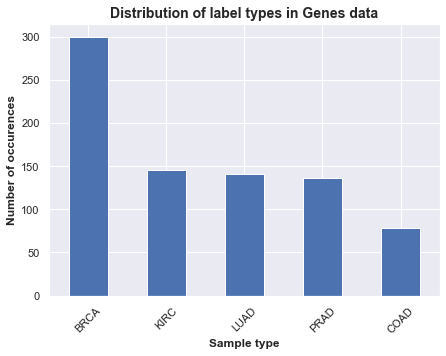

In [15]:
# visualize distribution of labels
fig = plt.figure(figsize=(7, 5))
exp.index.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.ylabel('Number of occurences', fontsize=12, fontweight='bold')
plt.xlabel('Sample type', fontsize=12, fontweight='bold')
plt.title('Distribution of label types in Genes data', fontsize=14, fontweight='bold')

Hence BRCA occurs the maximum times in our data.

Let we explore the data further by taking transpose of the data we got.

In [16]:
transpo_exp = exp.T

In [17]:
transpo_exp.head()

Class,BRCA,BRCA,BRCA,BRCA,BRCA,BRCA,BRCA,BRCA,BRCA,BRCA,...,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD
gene_0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.873341,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
gene_1,3.801873,3.277330,1.149975,4.538159,2.599770,2.568032,2.522156,2.543372,3.014962,2.215150,...,3.993285,1.978525,1.578649,3.086427,3.579301,3.190172,3.930822,2.676809,1.282262,2.325242
gene_2,5.025591,2.629846,0.462576,3.955722,2.562792,2.891341,2.916821,2.564476,3.355214,1.868845,...,5.367231,3.339465,2.090515,3.006101,3.432706,3.520573,4.049578,3.955629,2.998683,3.805932
gene_3,6.404150,6.000487,5.861427,6.259862,7.365491,7.864793,6.467187,6.299157,6.833712,6.287153,...,6.000973,5.970232,7.194708,6.645314,6.988014,7.210535,6.732256,6.639035,6.342914,6.530246
gene_4,9.564754,9.627027,10.092440,9.103243,10.462155,11.074610,10.010654,9.783317,9.487794,9.273963,...,9.852082,10.688906,10.290940,9.605192,9.470138,9.918593,9.806242,10.301165,9.983649,9.560367


In [18]:
transpo_exp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20531 entries, gene_0 to gene_20530
Columns: 801 entries, BRCA to PRAD
dtypes: float64(801)
memory usage: 126.2+ MB


In [19]:
transpo_exp.describe()

Class,BRCA,BRCA,BRCA,BRCA,BRCA,BRCA,BRCA,BRCA,BRCA,BRCA,...,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD
count,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000,...,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000,20531.000000
mean,6.557752,6.644628,6.155329,6.626141,6.396475,6.322263,6.288557,6.500574,6.415335,6.479712,...,6.438148,6.412983,6.312476,6.364915,6.651981,6.447557,6.396669,6.492097,6.594778,6.558847
std,3.981935,3.941968,4.187001,3.961697,4.064387,4.110591,4.125778,4.034278,4.069800,4.038053,...,4.038651,4.075581,4.073946,4.092079,3.952284,4.054061,4.051811,4.019520,3.980712,3.978511
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.043939,3.274754,1.645886,3.110881,2.485865,2.293194,2.108239,2.751099,2.535804,2.694769,...,2.605647,2.582965,2.363757,2.388823,3.325127,2.649753,2.506040,2.809517,3.085561,2.968326
50%,7.693717,7.901663,7.365981,7.793863,7.477078,7.383592,7.508714,7.634913,7.662205,7.657597,...,7.525897,7.401332,7.350117,7.458940,7.818825,7.549292,7.456174,7.606139,7.760587,7.735597
75%,9.724256,9.752221,9.631643,9.738612,9.705734,9.683990,9.665126,9.713660,9.676893,9.720757,...,9.706009,9.671866,9.662099,9.689575,9.751830,9.706758,9.670270,9.716877,9.725421,9.707233
max,16.955116,17.170835,17.409996,17.266942,17.242541,17.404551,16.911415,20.778829,17.343698,18.492745,...,18.604495,19.518175,16.354284,19.410091,18.357346,19.469570,18.476703,17.933898,18.059339,16.864488


So the range again of each gene classification expression value from 0 to 20+

## Data Preparation

In [20]:
features = list(exp.columns.values)
len(features)

20531

In [21]:
x = rna_exp[features].reset_index(drop=True)
y = labels

In [22]:
x.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [23]:
y.index = np.arange(0,801)

we scale our data such that each feature has unit variance. This is necessary because fitting algorithms highly depend on the scaling of the features. Here we use the StandardScaler module for scaling the features individually. StandardScaler subtracts the mean from each feature and then scales to unit variance.

In [24]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(x)

In [25]:
scaled_data

array([[-0.19479935, -0.82802988,  0.15980044, ..., -1.18793812,
        -0.11648251, -0.26190144],
       [-0.19479935, -2.01501735, -1.415042  , ..., -0.34227662,
        -1.65688871, -0.26190144],
       [-0.19479935,  0.41734754,  1.15673547, ...,  0.88686027,
        -1.85526414, -0.26190144],
       ...,
       [-0.19479935,  0.19888076,  0.57481583, ..., -0.22008186,
        -0.41046699,  1.3485582 ],
       [-0.19479935, -0.35045311, -0.28863152, ...,  1.43719268,
         0.09195083, -0.26190144],
       [-0.19479935, -0.57135218,  0.66725377, ...,  0.45087581,
        -0.47161901, -0.26190144]])

**Null Hypothesis testing for few features we have**

We have 5 categories of the output response. Let we test whether the all 5 categories are similar to one another or not based upon the gene expression of our very first 0th column.

In [26]:
# for this statistical method we will use statsmodel for feature selection using backward elimination
#! pip install statsmodels

In [27]:
from scipy import stats

In [28]:
grps = pd.unique(y['Class'])
d_data = {grp:x['gene_0'][y.Class == grp] for grp in grps}

so our data is ready and now let we put 5% threshold that if our p-value comes under 5% we can reject the null hypothesis for gene_0 other-wise we can accept it.

In [29]:
F, p = stats.f_oneway(d_data['PRAD'], d_data['LUAD'], d_data['BRCA'],d_data['KIRC'],d_data['COAD'])

print("p-value for significance is: ", p)

if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

p-value for significance is:  0.07505540778266195
accept null hypothesis


So we accepting this null hypothesis of all the catories are almost similar which is not true. Hence this gene_0 may not be better fit to classify cancer of the patients.

let we check for gene_1 and gene_2

In [30]:
d_data = {grp:x['gene_1'][y.Class == grp] for grp in grps}
F, p = stats.f_oneway(d_data['PRAD'], d_data['LUAD'], d_data['BRCA'],d_data['KIRC'],d_data['COAD'])

print("p-value for significance is: ", p)

if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

p-value for significance is:  4.315349359726914e-18
reject null hypothesis


In [31]:
d_data = {grp:x['gene_2'][y.Class == grp] for grp in grps}
F, p = stats.f_oneway(d_data['PRAD'], d_data['LUAD'], d_data['BRCA'],d_data['KIRC'],d_data['COAD'])

print("p-value for significance is: ", p)

if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

p-value for significance is:  2.1468844023159446e-44
reject null hypothesis


In [32]:
d_data = {grp:x['gene_3'][y.Class == grp] for grp in grps}
F, p = stats.f_oneway(d_data['PRAD'], d_data['LUAD'], d_data['BRCA'],d_data['KIRC'],d_data['COAD'])

print("p-value for significance is: ", p)

if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

p-value for significance is:  5.472971016870503e-77
reject null hypothesis


*Hence we are getting enough evidence based upon the p-value based upon we can reject the hypothesis that all 5 categories are not similar based upon the evidence we got from gene 1,2,3*

## Task 2 : Dimensionality Reduction

**The first method of feature reduction is correlation**

In [ ]:
dfCorr = rna_exp.corr()
filteredDF = dfCorr[((dfCorr >= 0.5) | (dfCorr <= -0.5)) & dfCorr != 1.0]

In [ ]:
plt.figure(figsize=(30,10))

sns.heatmap(filteredDF,annot=True,cmap="Reds")

plt.show()